In [1]:
#Importing necessary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers,regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
import Augmentor
import glob
warnings.filterwarnings('ignore')

In [2]:
#Importing the test and train datasets
data_dir_train = pathlib.Path("R:/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('R:/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
#Checking the count of images in the test and train dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train Data : ",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test Data : ",image_count_test)

Train Data :  2239
Test Data :  118


In [4]:
#Loading the dataset 
#Training Data
train_ds = image_dataset_from_directory(
    data_dir_train,
    labels='inferred',  
    label_mode='int',   
    batch_size=32,      
    image_size=(180, 180),  
    shuffle=True,       
    seed=123,           
    validation_split=0.2,  
    subset='training' )

#Validation Data
test_ds = image_dataset_from_directory(
    data_dir_test,
    labels='inferred',  
    label_mode='int',   
    batch_size=32,      
    image_size=(180, 180),  
    shuffle=False,       
    seed=123,           
    validation_split=0.2,  
    subset='validation' )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [5]:
#Showing the class labels
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


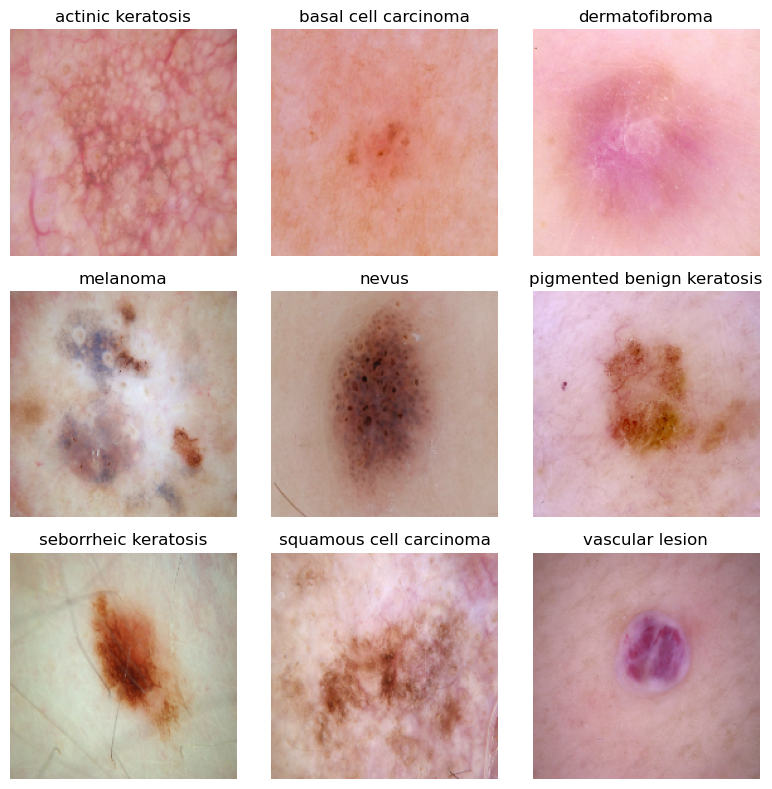

In [6]:
#Visualizing the data
plt.figure(figsize=(8, 8))
for i in range(len(class_names)):
    for images, labels in train_ds:
        if i in labels:
            image = images[labels == i][0]  
            break
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
#Data caching and prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
#Creating the model
#Before creating the model, Its good to rescale the dataset
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
#Model
num_classes = 9
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


In [9]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,612,553 (231.22 MB)

 Trainable params: 60,612,553 (231.22 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 865ms/step - accuracy: 0.2953 - loss: 3.1550 - val_accuracy: 0.0435 - val_loss: 2.8746
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 816ms/step - accuracy: 0.4388 - loss: 1.5644 - val_accuracy: 0.1304 - val_loss: 3.1552
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 841ms/step - accuracy: 0.5030 - loss: 1.3874 - val_accuracy: 0.2174 - val_loss: 2.8559
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 810ms/step - accuracy: 0.5387 - loss: 1.2852 - val_accuracy: 0.1739 - val_loss: 2.9594
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 847ms/step - accuracy: 0.6159 - loss: 1.0717 - val_accuracy: 0.0870 - val_loss: 4.9352
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 781ms/step - accuracy: 0.6845 - loss: 0.8966 - val_accuracy: 0.2609 - val_loss: 4.5089
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 776ms/step - accuracy: 0.7353 - loss: 0.7487 - val_accuracy: 0.2174 - val_loss: 5.7749
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 787ms/step - accuracy: 0.7441 - loss: 0.7627 - val_accu

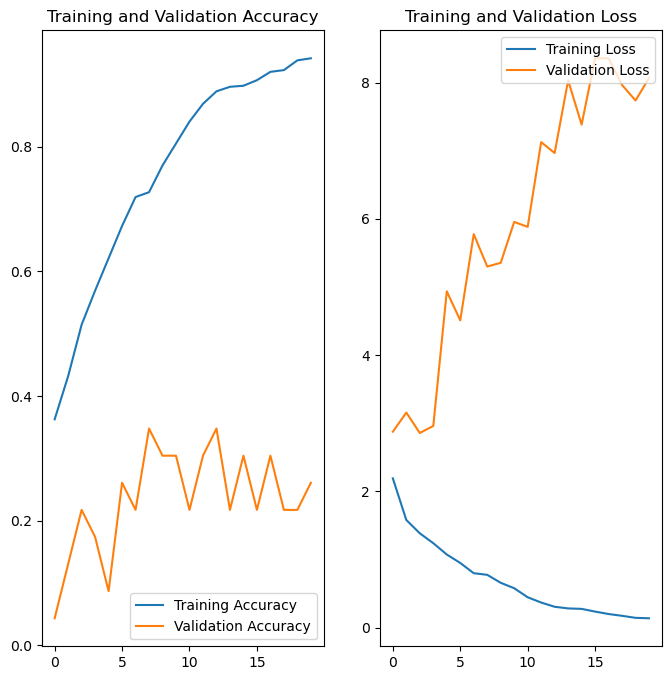

In [12]:
#plot the graphs for results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
#The training accuracy is steadily increasing, which indicates that the model is learning and fitting well to the training data.
#The validation accuracy is fluctuating and remains relatively low, suggesting that the model is not generalizing well to unseen data.
#The training loss remains very low (almost zero), further confirming that the model is fitting very well to the training data.
#The validation loss is significantly higher and increasing over time, indicating poor performance on the validation set.
#This indicates overfitting of the data.

In [14]:
#Choosing the appropriate augumentation strategy
#Flipping, Rotation and Zoom
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


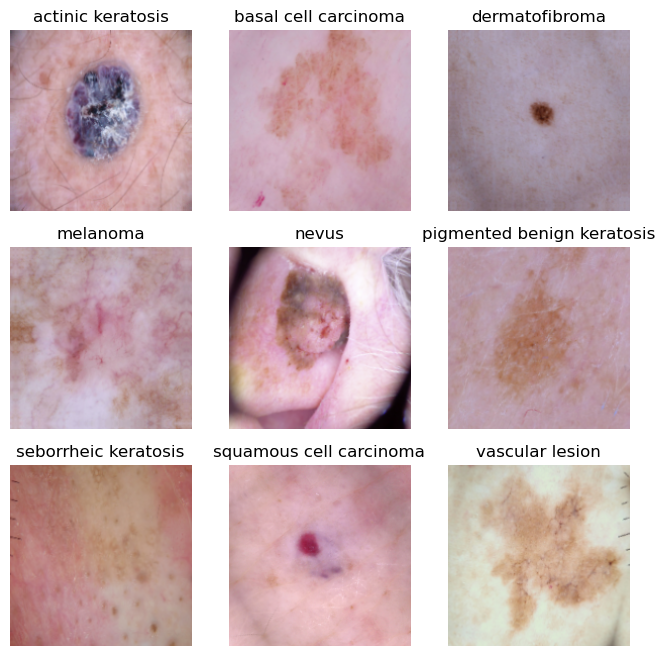

In [15]:
#Visualizing augumented data
#Visualizing the data
plt.figure(figsize=(8, 8))
for i in range(len(class_names)):
    for images, labels in augmented_train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            plt.title(class_names[i])
            plt.axis("off")
plt.show()

In [16]:
#Model using droupouts
train_ds = augmented_train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

dp_model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  # Adding dropout after flattening
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Adding dropout after dense layer
    layers.Dense(num_classes, activation='softmax')
])


In [17]:
# Compile the model
dp_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
dp_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,612,553 (231.22 MB)

 Trainable params: 60,612,553 (231.22 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#Training the model
epochs = 20
history = dp_model.fit(
  augmented_train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 54s 907ms/step - accuracy: 0.2224 - loss: 5.8046 - val_accuracy: 0.0000e+00 - val_loss: 2.8607
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 916ms/step - accuracy: 0.3723 - loss: 1.7775 - val_accuracy: 0.0000e+00 - val_loss: 9.3040
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 905ms/step - accuracy: 0.4238 - loss: 1.6127 - val_accuracy: 0.0000e+00 - val_loss: 17.6052
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 908ms/step - accuracy: 0.4026 - loss: 1.6467 - val_accuracy: 0.0000e+00 - val_loss: 67.3028
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 924ms/step - accuracy: 0.4493 - loss: 1.6066 - val_accuracy: 0.0000e+00 - val_loss: 66.5059
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 934ms/step - accuracy: 0.4629 - loss: 1.5254 - val_accuracy: 0.0000e+00 - val_loss: 95.8274
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 911ms/step - accuracy: 0.5087 - loss: 1.4316 - val_accuracy: 0.0000e+00 - val_loss: 75.0398
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 911ms/step - accuracy:

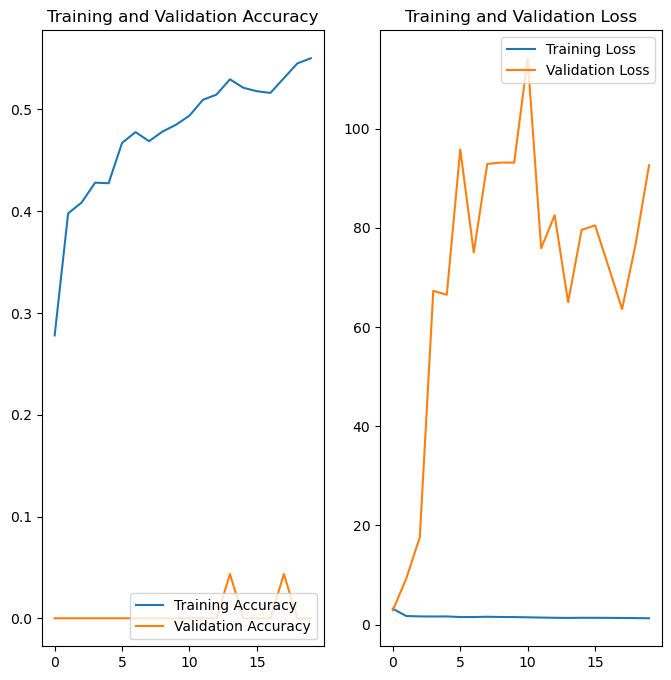

In [20]:
#plot the graphs for results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
#The model still behaves the same even if we add droupouts and augumented the data. It still overfits.


In [22]:
#Finding the distribution of classes in the dataset
#Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. 
#Class imbalance can have a detrimental effect on the final model quality.
#Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
def count_files(folder_path):
    total_files = 0
    for dirpath, _, filenames in os.walk(folder_path):
        total_files += len(filenames)
    return total_files

for folder in os.listdir(data_dir_train):
    folder_path = os.path.join(data_dir_train, folder)
    if os.path.isdir(folder_path):
        # Count files in the folder and its subdirectories
        num_files = count_files(folder_path)
        print(f"Folder '{folder}' has {num_files} files.")

Folder 'actinic keratosis' has 114 files.
Folder 'basal cell carcinoma' has 376 files.
Folder 'dermatofibroma' has 95 files.
Folder 'melanoma' has 438 files.
Folder 'nevus' has 357 files.
Folder 'pigmented benign keratosis' has 462 files.
Folder 'seborrheic keratosis' has 77 files.
Folder 'squamous cell carcinoma' has 181 files.
Folder 'vascular lesion' has 139 files.


In [24]:
#The class 'seborrheic keratosis' has the least number of data.
#The classes 'melanoma' and 'pigmented benign keratosis' has relatively more data (It dominates the dataset).

In [25]:
#Rectifying class imbalance
for i in class_names:
    p = Augmentor.Pipeline("R:/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

Initialised with 114 image(s) found.
Output directory set to R:/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1F0B4AB5710>: 100%|█| 1000/1000 [00:15<0


Initialised with 376 image(s) found.
Output directory set to R:/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F0B3A51D90>: 100%|█| 1000/1000 [00:15<00:00, 63.16 Sample


Initialised with 95 image(s) found.
Output directory set to R:/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1EFE63EBA90>: 100%|█| 1000/1000 [00:16<0


Initialised with 438 image(s) found.
Output directory set to R:/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1F0B4C15390>: 100%|█| 1000/1000 [01:24<00:00, 11.80 Sampl


Initialised with 357 image(s) found.
Output directory set to R:/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F0BC0B3550>: 100%|█| 1000/1000 [01:11<00:00, 14.06 Sample


Initialised with 462 image(s) found.
Output directory set to R:/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EFE61FB6D0>: 100%|█| 1000/1000 [00:16<00:00, 62.44 Sample


Initialised with 77 image(s) found.
Output directory set to R:/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1EFE630AB10>: 100%|█| 1000/1000 [00:36<00:00, 27.17 Sampl


Initialised with 181 image(s) found.
Output directory set to R:/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EFE61E4E50>: 100%|█| 1000/1000 [00:16<00:00, 61.95 Sample


Initialised with 139 image(s) found.
Output directory set to R:/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F0B4AB4AD0>: 100%|█| 1000/1000 [00:15<00:00, 63.71 Sample


In [26]:
#Checking the number of images
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


In [27]:
#Lets see the distribution of augmented data after adding new images to the original training data.
path_list = glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))
path_list[:10]

['R:\\Upgrad\\Dataset\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0f43dbf0-8929-4864-9e23-40cce1338adc.jpg',
 'R:\\Upgrad\\Dataset\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_17c637c9-db9c-4ad7-9262-86a79ddf10fb.jpg',
 'R:\\Upgrad\\Dataset\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_1e3cc291-f447-4cac-b7c4-5da9fcb690fc.jpg',
 'R:\\Upgrad\\Dataset\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2ae008e3-a7e9-4706-bee1-30323288f6a2.jpg',
 'R:\\Upgrad\\Dataset\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_35a31177

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:10]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [29]:
#Moving the newly created images to the training data
# Define path
train_folder = "R:/Upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

def move_files(source_dir, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    for filename in os.listdir(source_dir):
        if filename.endswith('.jpg'):  
            src = os.path.join(source_dir, filename)
            dest = os.path.join(dest_dir, filename)
            os.rename(src, dest)

for class_name in class_names:
    output_path = os.path.join(train_folder, class_name, "output")  
    train_path = os.path.join(train_folder, class_name)
    
    # Check if the output folder exists
    if os.path.exists(output_path):
        move_files(output_path, train_path)
        os.rmdir(output_path)  


In [30]:
#Checking the file distribution again
def count_files(folder_path):
    total_files = 0
    for dirpath, _, filenames in os.walk(folder_path):
        total_files += len(filenames)
    return total_files

for folder in os.listdir(data_dir_train):
    folder_path = os.path.join(data_dir_train, folder)
    if os.path.isdir(folder_path):
        # Count files in the folder and its subdirectories
        num_files = count_files(folder_path)
        print(f"Folder '{folder}' has {num_files} files.")

Folder 'actinic keratosis' has 1114 files.
Folder 'basal cell carcinoma' has 1376 files.
Folder 'dermatofibroma' has 1095 files.
Folder 'melanoma' has 1438 files.
Folder 'nevus' has 1357 files.
Folder 'pigmented benign keratosis' has 1462 files.
Folder 'seborrheic keratosis' has 1077 files.
Folder 'squamous cell carcinoma' has 1181 files.
Folder 'vascular lesion' has 1139 files.


In [31]:
#Loading the dataset again
#Training Data
train_ds_aug = image_dataset_from_directory(
    data_dir_train,
    labels='inferred',  
    label_mode='int',   
    batch_size=32,      
    image_size=(180, 180),  
    shuffle=True,       
    seed=123,           
    validation_split=0.2,  
    subset='training' )

#Validation Data
test_ds_aug = image_dataset_from_directory(
    data_dir_test,
    labels='inferred',  
    label_mode='int',   
    batch_size=32,      
    image_size=(180, 180),  
    shuffle=False,       
    seed=123,           
    validation_split=0.2,  
    subset='validation' )

Found 11239 files belonging to 9 classes.
Using 8992 files for training.
Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [32]:
#Data caching and prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_aug = train_ds_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds_aug = test_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
#Creating the model
#Before creating the model, Its good to rescale the dataset
normalization_layer = layers.Rescaling(1./255)
train_ds_aug = train_ds_aug.map(lambda x, y: (normalization_layer(x), y))
test_ds_aug = test_ds_aug.map(lambda x, y: (normalization_layer(x), y))
#Model using droupouts and batch normalization
dp_model_new = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dropout(0.6),  
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)), 
    layers.BatchNormalization(),
    layers.Dropout(0.6),  
    
    layers.Dense(num_classes, activation='softmax')
])



In [34]:
# Compile the model
dp_model_new.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
# View the summary of all layers
dp_model_new.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,614,985 (231.23 MB)

 Trainable params: 60,613,769 (231.22 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [40]:
#Training the model
epochs = 30
history = dp_model_new.fit(
  train_ds_aug,
  validation_data=test_ds_aug,
  epochs=epochs
)

Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.8643 - loss: 5.9666 - val_accuracy: 0.2174 - val_loss: 11.5030
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.8486 - loss: 6.1902 - val_accuracy: 0.1739 - val_loss: 16.3713
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.8536 - loss: 6.1562 - val_accuracy: 0.2174 - val_loss: 9.6617
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.8732 - loss: 5.9557 - val_accuracy: 0.1739 - val_loss: 13.3472
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - accuracy: 0.8492 - loss: 6.0530 - val_accuracy: 0.1739 - val_loss: 9.6551
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.8638 - loss: 5.9770 - val_accuracy: 0.3478 - val_loss: 8.9552
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.8699 - loss: 5.9515 - val_accuracy: 0.3913 - val_loss: 9.6128
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.8524 - loss: 6.3331 - val_a

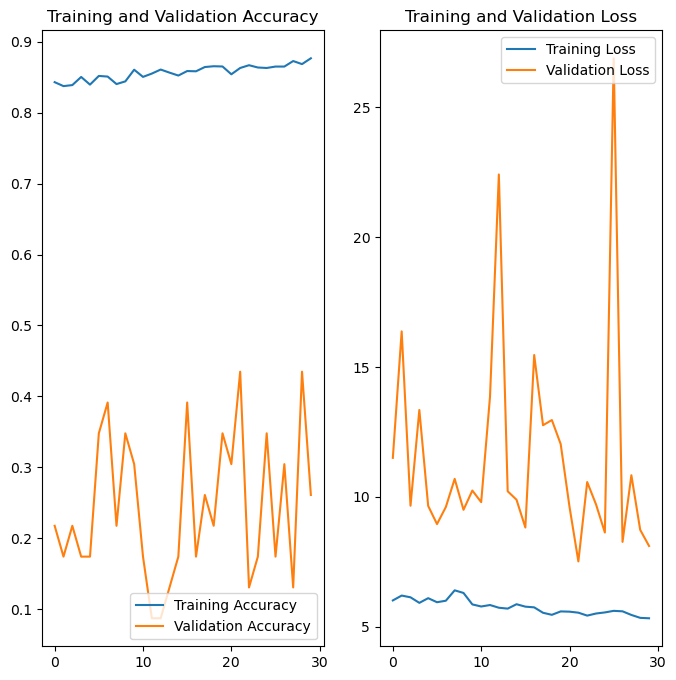

In [41]:
#plot the graphs for results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
#Now we can see that the validation accuracy went far more better than the other two models even it overfits. But Adding more data for reducing class imbalance makes the model better.